In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import numpy as np
import re

In [2]:
### EDA video_games_sales.csv ###
df_video_games = pd.read_csv('Data/video_games_sales.csv')
print("Primeras filas del dataset")
print(df_video_games.head(10))



Primeras filas del dataset
   Rank                       Name Platform    Year         Genre Publisher  \
0     1                 Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2          Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3             Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4          Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5   Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   
5     6                     Tetris       GB  1989.0        Puzzle  Nintendo   
6     7      New Super Mario Bros.       DS  2006.0      Platform  Nintendo   
7     8                   Wii Play      Wii  2006.0          Misc  Nintendo   
8     9  New Super Mario Bros. Wii      Wii  2009.0      Platform  Nintendo   
9    10                  Duck Hunt      NES  1984.0       Shooter  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.

In [3]:
print("\nDimensiones del dataset:")
print(f"Filas: {df_video_games.shape[0]}, Columnas: {df_video_games.shape[1]}")


Dimensiones del dataset:
Filas: 16598, Columnas: 11


In [4]:
print("\nValores nulos por columna:")
print(df_video_games.isnull().sum())


Valores nulos por columna:
Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


In [5]:
## limpieza de video_games_sales.csv --> video_game_sales_limpio ##
df_video_games1 = df_video_games.drop_duplicates()
df_video_games2 = df_video_games1.dropna(subset=['Year', 'Publisher'])
df_video_games_limpio = df_video_games2[df_video_games2['Global_Sales'] > 0] # & df_video_games2['Global_Sales'] < 40
df_video_games_limpio['Year'] = df_video_games_limpio['Year'].astype(int)

In [6]:
print(f"Filas: {df_video_games_limpio.shape[0]}, Columnas: {df_video_games_limpio.shape[1]}")
print(df_video_games_limpio.dtypes)

Filas: 16291, Columnas: 11
Rank              int64
Name             object
Platform         object
Year              int64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object


In [7]:
df_video_games_limpio.to_csv('Data/video_games_sales_limpio.csv', index=False)

In [8]:
#### categorización de ventas ####
q90 = df_video_games_limpio['Global_Sales'].quantile(0.90)
q60 = df_video_games_limpio['Global_Sales'].quantile(0.60)
def clasificar_ventas(ventas):
    if ventas >= q90:
        return 'Muy Alta'
    elif ventas >= q60:
        return 'Alta'
    else:
        return 'Normal'
 ## incluir nueva columna ###   
df_video_games_limpio['Ventas_Clase'] = df_video_games_limpio['Global_Sales'].apply(clasificar_ventas)
df_video_games_limpio.to_csv('Data/video_games_sales_limpio.csv', index=False)

In [9]:
## Union de video_games_ sales_ limpio y all_video_games(cleaned).csv ##
df_all_games = pd.read_csv('Data/all_video_games(cleaned).csv')

In [10]:
df_video_games_limpio['Title'] = df_video_games_limpio['Name'].str.strip().str.lower()
df_all_games['Title'] = df_all_games['Title'].str.strip().str.lower()
df_all_games_limpio = df_all_games[['Title', 'Product Rating', 'User Score', 'User Ratings Count', 'Platforms Info']]

In [11]:
df_video_games_unido = pd.merge(df_video_games_limpio, df_all_games_limpio, on='Title', how='left')

In [12]:
# eliminamos columnas inneecesarias ## 
df_video_games_unido.drop(columns=['Rank','Title', 'Platforms Info'], inplace=True) ## dudas de meter plataformas info y  ##

In [13]:
df_video_games_unido['User Ratings Count'] = (
    df_video_games_unido.groupby(['Platform', 'Genre'])['User Ratings Count']
      .transform(lambda x: x.fillna(x.median()))
)
df_video_games_unido['User Ratings Count'] = df_video_games_unido['User Ratings Count'] \
    .fillna(df_video_games_unido['User Ratings Count'].median())
df_video_games_unido['User Ratings Count'] = df_video_games_unido['User Ratings Count'].round().astype(int)

In [14]:
#eliminacion de consolas con menos de 20 filas registradas #
platform_counts = df_video_games_unido['Platform'].value_counts()
platforms_to_remove = platform_counts[platform_counts < 20].index.tolist()
df_video_games_unido = df_video_games_unido[~df_video_games_unido['Platform'].isin(platforms_to_remove)].copy()


In [15]:
#renombramos la columna platform ##
# Diccionario de reemplazo de nombres de plataformas
platform_rename = {
    '2600': 'Atari 2600',
    'DS': 'Nintendo DS',
    'GB': 'Game Boy',
    'GBA': 'Game Boy Advance',
    'GC': 'GameCube',
    'GEN': 'Sega Genesis',
    'N64': 'Nintendo 64',
    'NES': 'Nintendo Entertainment System',
    'PC': 'PC',
    'PS': 'PlayStation',
    'PS2': 'PlayStation 2',
    'PS3': 'PlayStation 3',
    'PS4': 'PlayStation 4',
    'PSP': 'PlayStation Portable',
    'PSV': 'PlayStation Vita',
    'SAT': 'Sega Saturn',
    'SNES': 'Super Nintendo Entertainment System',
    'Wii': 'Nintendo Wii',
    'WiiU': 'Nintendo Wii U',
    'X360': 'Xbox 360',
    'XB': 'Xbox',
    'XOne': 'Xbox One',
    'DC': 'Dream Cast',
    '3DS': 'Nintendo 3DS',
}

# Reemplazar los nombres
df_video_games_unido['Platform'] = df_video_games_unido['Platform'].replace(platform_rename)


In [16]:
## Eliminamos filas con "Rated RP FOr Rate Pending"
##Renombramos la columna Product Rating por Nota PEGI ##
df_video_games_unido.rename(columns={'Product Rating': 'Nota PEGI'}, inplace=True)
df_video_games_unido = df_video_games_unido[df_video_games_unido['Nota PEGI'] != 'Rated RP For Rate Pending'].copy()


In [17]:
## Remplazamos las filas de Nota PEGI por valores correspondientes ##
nota_pegi_rename = {
    'Rated E For Everyone': '3',
    'Rated M For Mature': '18',
    'Rated T For Teen': '16',
    'Rated E +10 For Everyone +10': '12',
}
df_video_games_unido['Nota PEGI'] = df_video_games_unido['Nota PEGI'].replace(nota_pegi_rename)

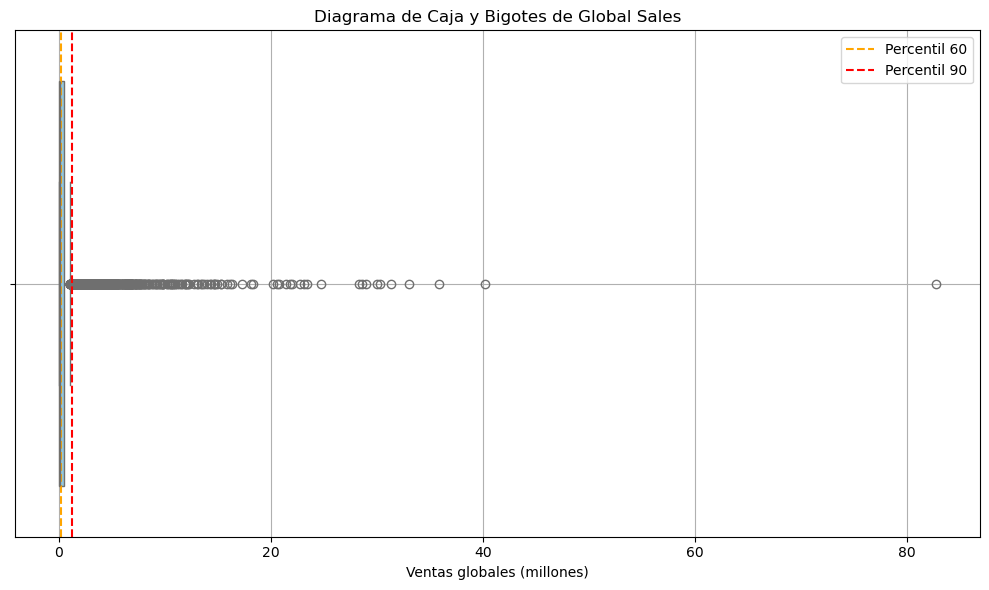

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_video_games_unido['Global_Sales'], color='skyblue')
plt.axvline(x=q60, color='orange', linestyle='--', label='Percentil 60')
plt.axvline(x=q90, color='red', linestyle='--', label='Percentil 90')
plt.title('Diagrama de Caja y Bigotes de Global Sales')
plt.xlabel('Ventas globales (millones)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
## clasificamos las consolas en funcion de su antiguedad ##
mercado_activo = [
    'PlayStation 4','PC', 
    'Xbox One'
]
mercado_secundario = [
    'Nintendo 3DS',
    'PlayStation Vita'
]
# Función para clasificar en Actual u Obsoleta
def clasificar_consola(plataforma):
    if plataforma in mercado_activo:
        return 'Consola Activa'
    elif plataforma in mercado_secundario:
        return 'Consola Secundaria'
    else:
        return 'Consola Obsoleta'

#Anañidos nueva columna #
df_video_games_unido['Estado_Consola'] = df_video_games_unido['Platform'].apply(clasificar_consola)

In [20]:
### añadimo la columna precios, basado en estimaciones del mercado, en momento ##
platform_prices_eur = {
    'PlayStation 4': 69.99,
    'Xbox One': 69.99,
    'PC': 49.99,
    'PlayStation 3': 59.99,
    'Xbox 360': 59.99,
    'Nintendo Wii U': 59.99,
    'Nintendo Wii': 49.99,
    'Nintendo DS': 39.99,
    'Nintendo 3DS': 39.99,
    'PlayStation 2': 49.99,
    'PlayStation Portable': 39.99,
    'Nintendo Entertainment System': 49.99,
    'Super Nintendo Entertainment System': 59.99,
    'Game Boy': 39.99,
    'PlayStation': 49.99,
    'Game Boy Advance': 39.99,
    'Nintendo 64': 59.99,
    'Xbox': 59.99,
    'Atari 2600': 29.99,
    'GameCube': 49.99,
    'Sega Genesis': 49.99,
    'Dream Cast': 49.99,
    'PlayStation Vita': 49.99,
    'Sega Saturn': 59.99,
}
def assign_launch_price(row):
    platform = row['Platform']
    return platform_prices_eur.get(platform)
df_video_games_unido['Price'] = df_video_games_unido.apply(assign_launch_price, axis=1)


In [21]:
# anañidos el precio de las consolas cuando salieron al mercado #
price_dict = {
    'Nintendo Wii': 249,
    'Nintendo Entertainment System': 199,  
    'Game Boy': 113.5,
    'Nintendo DS': 149,
    'Xbox 360': 299,
    'PlayStation 3': 599,
    'PlayStation 2': 399,
    'Super Nintendo Entertainment System': 299,
    'Game Boy Advance': 120,
    'Nintendo 3DS': 250,
    'PlayStation 4': 399,
    'Nintendo 64': 210,
    'PlayStation': 299,
    'Xbox': 299,
    'PC': 230,
    'Atari 2600': 199,
    'PlayStation Portable': 249,
    'Xbox One': 499,
    'GameCube': 199,
    'Nintendo Wii U': 299, 
    'Sega Genesis': 199,
    'Dream Cast': 240,
    'PlayStation Vita': 249,
    'Sega Saturn': 399
}
def assign_launch_price_platform(row):
    platform = row['Platform']
    return price_dict.get(platform)
df_video_games_unido['Price_Platform'] = df_video_games_unido.apply(assign_launch_price_platform, axis=1)

In [22]:
## Rellenamos los valores nulos de 'User Score' con la media en base a 'Genre' y 'Platform' ##
def imputar_user_score(row):
    if pd.isna(row['User Score']):
        media = df_video_games_unido[
            (df_video_games_unido['Platform'] == row['Platform']) &
            (df_video_games_unido['Genre'] == row['Genre'])
        ]['User Score'].mean()
        return media
    else:
        return row['User Score']
df_video_games_unido['User Score'] = df_video_games_unido.apply(imputar_user_score, axis=1)
df_video_games_unido['User Score'].fillna(df_video_games_unido['User Score'].mean(), inplace=True)


C:\Users\pablo\AppData\Local\Temp\ipykernel_2220\2351189849.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_video_games_unido['User Score'].fillna(df_video_games_unido['User Score'].mean(), inplace=True)


In [23]:
## Rellenamos los valores nulos de 'Nota PEGI' con la moda en base a 'Genre' y 'Platform' ##
def imputar_pegi(row):
    if pd.isna(row['Nota PEGI']):
        subset = df_video_games_unido[
            (df_video_games_unido['Platform'] == row['Platform']) &
            (df_video_games_unido['Genre'] == row['Genre'])
        ]['Nota PEGI']
        moda = subset.mode()
        return moda[0] if not moda.empty else np.nan
    else:
        return row['Nota PEGI']
df_video_games_unido['Nota PEGI'] = df_video_games_unido.apply(imputar_pegi, axis=1)
df_video_games_unido['Nota PEGI'].fillna(df_video_games_unido['Nota PEGI'].mode()[0],inplace=True)

C:\Users\pablo\AppData\Local\Temp\ipykernel_2220\195433462.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_video_games_unido['Nota PEGI'].fillna(df_video_games_unido['Nota PEGI'].mode()[0],inplace=True)


In [24]:
# Anadismos una columna que muestre el año de lanzamiento de la consola #
year_lanzamiento = {
    'Atari 2600': 1977, 'Nintendo DS': 2004, 'Game Boy Advance': 2001,
    'GameCube': 2001, 'Sega Genesis': 1988, 'Nintendo 64': 1996, 'Nintendo Entertainment System': 1983, 'PC': 1980,
    'PlayStation': 1994, 'PlayStation 2': 2000, 'PlayStation 3': 2006, 'PlayStation 4': 2013, 'PlayStation Portable': 2004, 
    'PlayStation Vita': 2011, 'Sega Saturn': 1994, 'Super Nintendo Entertainment System': 1990,
    'Nintendo Wii': 2006, 'Nintendo Wii U': 2012, 'Xbox 360': 2005, 'Xbox': 2001, 'Xbox One': 2013,
    'Game Boy': 1989, 'Dream Cast': 1998, 'Nintendo 3DS': 2011
}
df_video_games_unido['Year_Consola'] = df_video_games_unido['Platform'].map(year_lanzamiento)

In [25]:
## Añadimos la duracion media de los videojuesgos segun consola y genero ##
playtime_dict = {
    ('Action', 'Nintendo Wii'): 10,
    ('Adventure', 'Nintendo Wii'): 20,
    ('Fighting', 'Nintendo Wii'): 4,
    ('Misc', 'Nintendo Wii'): 2,
    ('Platform', 'Nintendo Wii'): 10,
    ('Puzzle', 'Nintendo Wii'): 5,
    ('Racing', 'Nintendo Wii'): 6,
    ('Role-Playing', 'Nintendo Wii'): 40,
    ('Shooter', 'Nintendo Wii'): 8,
    ('Simulation', 'Nintendo Wii'): 20,
    ('Sports', 'Nintendo Wii'): 1,
    ('Strategy', 'Nintendo Wii'): 40,
    ('Action', 'Nintendo Entertainment System'): 2,
    ('Adventure', 'Nintendo Entertainment System'): 4,
    ('Platform', 'Nintendo Entertainment System'): 3,
    ('Puzzle', 'Nintendo Entertainment System'): 3,
    ('Racing', 'Nintendo Entertainment System'): 1,
    ('Role-Playing', 'Nintendo Entertainment System'): 18,
    ('Shooter', 'Nintendo Entertainment System'): 1,
    ('Sports', 'Nintendo Entertainment System'): 1,
    ('Strategy', 'Nintendo Entertainment System'): 10,
    ('Misc', 'Nintendo Entertainment System'): 1,
    ('Action', 'Game Boy'): 1,
    ('Adventure', 'Game Boy'): 15,
    ('Platform', 'Game Boy'): 1.5,
    ('Racing', 'Game Boy'): 1,
    ('Role-Playing', 'Game Boy'): 20,
    ('Action', 'Nintendo DS'): 7,
    ('Adventure', 'Nintendo DS'): 15,
    ('Fighting', 'Nintendo DS'): 2,
    ('Misc', 'Nintendo DS'): 3,
    ('Platform', 'Nintendo DS'): 6,
    ('Puzzle', 'Nintendo DS'): 10,
    ('Racing', 'Nintendo DS'): 5,
    ('Role-Playing', 'Nintendo DS'): 25,
    ('Shooter', 'Nintendo DS'): 6,
    ('Simulation', 'Nintendo DS'): 5,
    ('Sports', 'Nintendo DS'): 2,
    ('Strategy', 'Nintendo DS'): 18,
    ('Action', 'PlayStation 2'): 15,
    ('Action', 'PlayStation 3'): 12,
    ('Action', 'Nintendo Wii U'): 15,
    ('Adventure', 'Nintendo Wii U'): 37,
    ('Fighting', 'Nintendo Wii U'): 2,
    ('Misc', 'Nintendo Wii U'): 3,
    ('Platform', 'Nintendo Wii U'): 9,
    ('Puzzle', 'nintendo Wii U'): 6,
    ('Racing', 'Nintendo Wii U'): 6,
    ('Role-Playing', 'Nintendo Wii U'): 70,
    ('Shooter', 'Nintendo Wii U'): 6,
    ('Sports', 'Nintendo Wii U'): 1,
    ('Strategy', 'Nintendo wii U'): 8,
    ('Fighting', 'PC'): 3,
    ('Platform', 'PC'): 5,
    ('Puzzle', 'PlayStation 4'): 5,
    ('Racing', 'PlayStation 4'): 6,
    ('Role-Playing', 'PlayStation 4'): 50,
    ('Shooter', 'PlayStation 4'): 8,
    ('Simulation', 'PlayStation 4'): 20,
    ('Sports', 'PlayStation 4'): 1,
    ('Strategy', 'PlayStation 4'): 40,
    ('Action', 'Xbox One'): 15,
    ('Adventure', 'Xbox One'): 37,
    ('Fighting', 'Xbox One'): 2,
    ('Misc', 'Xbox One'): 3,
    ('Platform', 'Xbox One'): 9,
    ('Puzzle', 'Xbox One'): 6,
    ('Racing', 'Xbox One'): 6,
    ('Role-Playing', 'Xbox One'): 70,
    ('Shooter', 'Xbox One'): 6,
    ('Sports', 'Xbox One'): 1,
    ('Strategy', 'Xbox One'): 8
}

def asignar_playtime(row):
    genre = str(row['Genre']).strip()
    platform = str(row['Platform']).strip()
    return playtime_dict.get((genre, platform), np.nan)

def imputar_si_falta(row):
    media_por_genero = df_video_games_unido.groupby('Genre')['Play Time'].mean()
    if pd.isna(row['Play Time']):
        return media_por_genero.get(row['Genre'], np.nan)
    else:
        return row['Play Time']

# Crear nueva columna con el tiempo de juego
df_video_games_unido['Play Time'] = df_video_games_unido.apply(asignar_playtime, axis=1)
df_video_games_unido['Play Time'] = df_video_games_unido.apply(imputar_si_falta, axis=1)


In [26]:
# añadimos nueva columna con el modo de juego #
multijugador_comun = {
    'Sports': True,
    'Platform': False,
    'Racing': True,
    'Role-Playing': False,
    'Puzzle': False,
    'Misc': True,
    'Shooter': True,
    'Simulation': False,
    'Action': True,
    'Fighting': True,
    'Adventure': False,
    'Strategy': True
}
def clasificar_modo_juego(genero):
    if multijugador_comun.get(genero, True):
        return 'Multijugador'
    else:
        return 'Individual'
df_video_games_unido['Modo Juego'] = df_video_games_unido['Genre'].apply(clasificar_modo_juego)

In [27]:
# Calcular años desde lanzamiento de la consola
df_video_games_unido['Años_desde_lanzamiento_consola'] = df_video_games_unido['Year'] - df_video_games_unido['Year_Consola']

In [28]:

# Proporción de precio relativo al promedio de plataforma
df_video_games_unido['Precio_relativo'] = df_video_games_unido['Price'] / df_video_games_unido['Price_Platform']

In [29]:
# Categorizamos nota PEGI
df_video_games_unido['Nota PEGI'] = df_video_games_unido['Nota PEGI'].astype(int)
def categorizar_pegi(nota):
    if nota <= 7: return 'Infantil'
    elif nota < 16: return 'Adolescente'
    else: return 'Adulto'
df_video_games_unido['PEGI_categoria'] = df_video_games_unido['Nota PEGI'].apply(categorizar_pegi)

In [30]:
# Categorizamos la duración del juego
df_video_games_unido['Duracion_juego_cat'] = pd.cut(df_video_games_unido['Play Time'], bins=[0, 5, 20, float('inf')], 
                                  labels=['Corto', 'Medio', 'Largo'])

In [31]:
### pertenece a una saga o no ###

def extraer_nombre_base(nombre):
    nombre = nombre.lower()
    nombre = re.sub(r'\(.*?\)|\[.*?\]', '', nombre)  # eliminar paréntesis
    nombre = re.sub(r'[-_:]', ' ', nombre)  # quitar guiones y dos puntos
    nombre = re.sub(r'\b(remaster(ed)?|hd|ultimate|edition|goty|game of the year|definitive|complete|deluxe)\b', '', nombre)
    nombre = re.sub(r'\b([ivx]+|\d{1,2})\b', '', nombre)  # quitar romanos y números
    nombre = re.sub(r'[^a-zA-Z\s]', '', nombre)  # eliminar símbolos
    nombre = re.sub(r'\s+', ' ', nombre).strip()
    return nombre

# Aplicar limpieza
df_video_games_unido['Nombre_Base'] = df_video_games_unido['Name'].apply(extraer_nombre_base)

# Detectar sagas: si ese nombre base aparece más de una vez
conteo = df_video_games_unido['Nombre_Base'].value_counts()
df_video_games_unido['Es_Saga'] = df_video_games_unido['Nombre_Base'].apply(lambda x: 1 if conteo.get(x, 0) > 1 else 0)
df_video_games_unido['Tipo_Saga'] = df_video_games_unido['Es_Saga'].apply(lambda x: 'Saga' if x == 1 else 'No saga')


In [32]:
## Añadimos la columna situacion economica global en base a year ##
recesion = {
    1980, 1981, 1982, 1983, 1991, 1992, 2001,
    2008, 2009, 2020
}

df_video_games_unido['Situacion_Economica'] = df_video_games_unido['Year'].apply(
    lambda x: 'Recesion' if x in recesion else 'Crecimiento'
)


In [33]:
print(df_video_games_unido['Ventas_Clase'].value_counts())

Ventas_Clase
Normal      9607
Alta        5020
Muy Alta    1632
Name: count, dtype: int64


In [34]:
print("Forma del dataframe combinado:", df_video_games_unido.shape)
print(df_video_games_unido.isnull().sum())

Forma del dataframe combinado: (16259, 28)
Name                              0
Platform                          0
Year                              0
Genre                             0
Publisher                         0
NA_Sales                          0
EU_Sales                          0
JP_Sales                          0
Other_Sales                       0
Global_Sales                      0
Ventas_Clase                      0
Nota PEGI                         0
User Score                        0
User Ratings Count                0
Estado_Consola                    0
Price                             0
Price_Platform                    0
Year_Consola                      0
Play Time                         0
Modo Juego                        0
Años_desde_lanzamiento_consola    0
Precio_relativo                   0
PEGI_categoria                    0
Duracion_juego_cat                0
Nombre_Base                       0
Es_Saga                           0
Tipo_Saga            

In [35]:
print(df_video_games_unido.columns.unique())

Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Ventas_Clase',
       'Nota PEGI', 'User Score', 'User Ratings Count', 'Estado_Consola',
       'Price', 'Price_Platform', 'Year_Consola', 'Play Time', 'Modo Juego',
       'Años_desde_lanzamiento_consola', 'Precio_relativo', 'PEGI_categoria',
       'Duracion_juego_cat', 'Nombre_Base', 'Es_Saga', 'Tipo_Saga',
       'Situacion_Economica'],
      dtype='object')


In [36]:
df_video_games_unido.to_csv('Data/video_games_sales_completo.csv', index=False)

In [37]:
for clase in ['Normal', 'Alta', 'Muy Alta']:
    subset = df_video_games_unido[df_video_games_unido['Ventas_Clase'] == clase]
    minimo = subset['Global_Sales'].min()
    maximo = subset['Global_Sales'].max()
    print(f"{clase}: entre {minimo:.2f} y {maximo:.2f} millones de unidades vendidas.")

Normal: entre 0.01 y 0.24 millones de unidades vendidas.
Alta: entre 0.25 y 1.21 millones de unidades vendidas.
Muy Alta: entre 1.22 y 82.74 millones de unidades vendidas.


In [38]:
#valores_unicos = df_video_games_unido['Situacion_Economica'].unique().tolist()
valor_min = df_video_games_unido['User Ratings Count'].max()
print(valor_min)
#print(valores_unicos)

24855


In [39]:
valor_objetivo = 'Obsoleta'  # reemplaza con el valor que te interesa
valores_filtrados = df_video_games_unido[df_video_games_unido['Estado_Consola'] == valor_objetivo]['Platform'].unique().tolist()
print(valores_filtrados)

[]


In [40]:
print(df_video_games_unido['Publisher'].unique().tolist())

['Nintendo', 'Microsoft Game Studios', 'Take-Two Interactive', 'Sony Computer Entertainment', 'Activision', 'Ubisoft', 'Bethesda Softworks', 'Electronic Arts', 'Sega', 'SquareSoft', 'Atari', '505 Games', 'Capcom', 'GT Interactive', 'Konami Digital Entertainment', 'Sony Computer Entertainment Europe', 'Square Enix', 'LucasArts', 'Virgin Interactive', 'Warner Bros. Interactive Entertainment', 'Universal Interactive', 'Eidos Interactive', 'RedOctane', 'Vivendi Games', 'Enix Corporation', 'Namco Bandai Games', 'Palcom', 'Hasbro Interactive', 'THQ', 'Fox Interactive', 'Acclaim Entertainment', 'MTV Games', 'Disney Interactive Studios', 'Majesco Entertainment', 'Codemasters', 'Red Orb', 'Level 5', 'Arena Entertainment', 'Midway Games', 'JVC', 'Deep Silver', '989 Studios', 'NCSoft', 'UEP Systems', 'Parker Bros.', 'Maxis', 'Imagic', 'Tecmo Koei', 'Valve Software', 'ASCII Entertainment', 'Mindscape', 'Infogrames', 'Unknown', 'Square', 'Valve', 'Activision Value', 'Banpresto', 'D3Publisher', 'Oxy

In [41]:
df_video_games_unido

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,Play Time,Modo Juego,Años_desde_lanzamiento_consola,Precio_relativo,PEGI_categoria,Duracion_juego_cat,Nombre_Base,Es_Saga,Tipo_Saga,Situacion_Economica
0,Wii Sports,Nintendo Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,...,1.000000,Multijugador,0,0.200763,Infantil,Corto,wii sports,0,No saga,Crecimiento
1,Super Mario Bros.,Nintendo Entertainment System,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,...,3.000000,Individual,2,0.251206,Infantil,Corto,super mario bros,1,Saga,Crecimiento
2,Mario Kart Wii,Nintendo Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,...,6.000000,Multijugador,2,0.200763,Infantil,Medio,mario kart wii,0,No saga,Recesion
3,Wii Sports Resort,Nintendo Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,...,1.000000,Multijugador,3,0.200763,Infantil,Corto,wii sports resort,0,No saga,Recesion
4,Pokemon Red/Pokemon Blue,Game Boy,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,...,20.000000,Individual,7,0.352335,Infantil,Medio,pokemon redpokemon blue,0,No saga,Crecimiento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16286,Woody Woodpecker in Crazy Castle 5,Game Boy Advance,2002,Platform,Kemco,0.01,0.00,0.00,0.00,0.01,...,6.502242,Individual,1,0.333250,Infantil,Medio,woody woodpecker in crazy castle,0,No saga,Crecimiento
16287,Men in Black II: Alien Escape,GameCube,2003,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01,...,6.828877,Multijugador,2,0.251206,Adulto,Medio,men in black alien escape,1,Saga,Crecimiento
16288,SCORE International Baja 1000: The Official Game,PlayStation 2,2008,Racing,Activision,0.00,0.00,0.00,0.00,0.01,...,5.527094,Multijugador,8,0.125288,Infantil,Medio,score international baja the official game,1,Saga,Recesion
16289,Know How 2,Nintendo DS,2010,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01,...,10.000000,Individual,6,0.268389,Infantil,Medio,know how,0,No saga,Crecimiento
